In [1]:
import numpy as np
from typing import List, Dict, Set, Any, Optional, Tuple, Literal, Callable
from time import time

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_percentage_error

from SWIM_orig import DenseSWIM

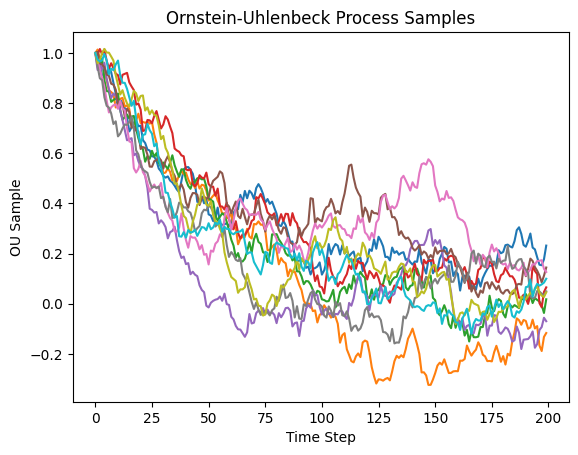

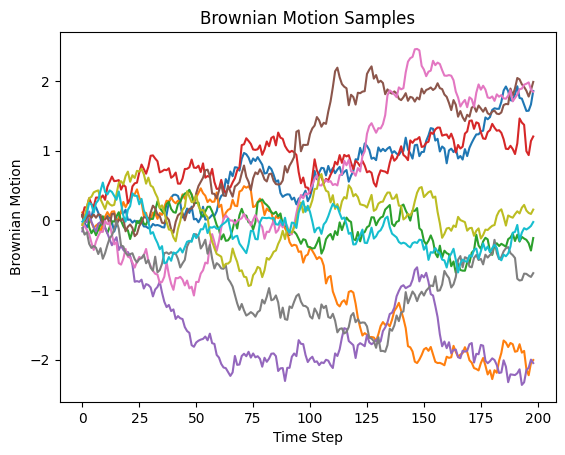

In [2]:
def generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0):
    """
    Simulate a 1-dimensional Ornstein-Uhlenbeck process using the Milstein method.

    Parameters:
        n_samples (int): Number of samples to generate.
        n_steps (int): Number of time steps to simulate.
        dt (float): Time increment between steps.
        theta (float): Mean reversion rate.
        mu (float): Long-term mean.
        sigma (float): Volatility.
        x0 (float): Initial value.

    Returns:
        numpy.ndarray: Array of shape (n_steps,) with the simulated process.
    """
    # Preallocate array for the process values
    X = np.zeros( (n_samples, n_steps) )
    X[:, 0] = x0

    dW = np.random.randn(n_samples, n_steps-1) * np.sqrt(dt)

    # Generate the 1D OU process using the Milstein method
    for t in range(1, n_steps):
        # Generate standard normal random variable for Wiener process increment

        X[:, t] = X[:, t-1] + theta * (mu - X[:, t-1]) * dt + sigma * dW[:, t-1]

    return X, dW

# Example usage
n_samples = 100  # Number of samples
n_steps = 200  # Number of time steps
dt = 0.01       # Time step size
theta = 2.0     # Mean reversion rate
mu = 0.0        # Long-term mean
sigma = 0.3     # Volatility
x0 = 1.0        # Initial value

# Generate samples
OU_samples, dW = generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0)
W = np.cumsum(dW, axis=1)

# Plot the OU samples
plt.plot(OU_samples[:10].T)
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Ornstein-Uhlenbeck Process Samples')
plt.show()

plt.plot(W[:10].T)
plt.xlabel('Time Step')
plt.ylabel('Brownian Motion')
plt.title('Brownian Motion Samples')
plt.show()

# ridge regression

Relative L2 error: 0.029717515554642245
Test R^2 score: 0.9887039110631874
Test MAPE: 0.6033723357831549
ridge alpha: 0.03125


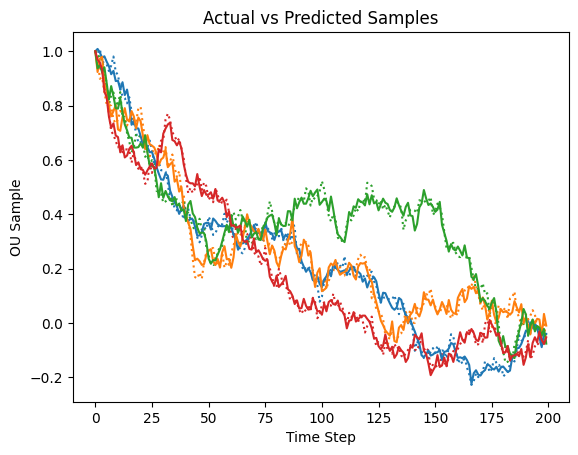

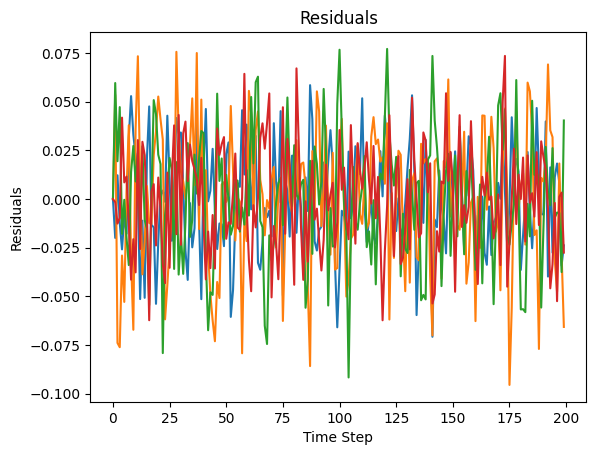

In [3]:
def eval_scores(pred, y):
    # pred and y are shape (n_samples, d)
    rel_l2 = np.linalg.norm(pred-y, ord=2) / np.linalg.norm(y, ord=2)
    r2 = 1 - np.sum((pred-y)**2) / np.sum((y-np.mean(y))**2) #is this correct for multi-dim?
    mape = mean_absolute_percentage_error(y, pred)
    print(f"Relative L2 error: {rel_l2}")
    print(f"Test R^2 score: {r2}")
    print(f"Test MAPE: {mape}")
    return mape

# Create the ridge regression model
ridge_model = RidgeCV(alphas=[2**i for i in range(-5, 2)])
n = len(OU_samples)
train_OU = OU_samples[:n//2]
test_OU = OU_samples[n//2:]
train_W = W[:n//2]
test_W = W[n//2:]


# Fit the model to the data
ridge_model.fit(train_W, train_OU)

# Predict the OU samples using the noise
pred = ridge_model.predict(test_W)
eval_scores(pred, test_OU)
print("ridge alpha:", ridge_model.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# DenseSWIM

Relative L2 error: 0.06826200328890161
Test R^2 score: 0.9527079655677458
Test MAPE: 1.0702226978091423
alpha: 0.5


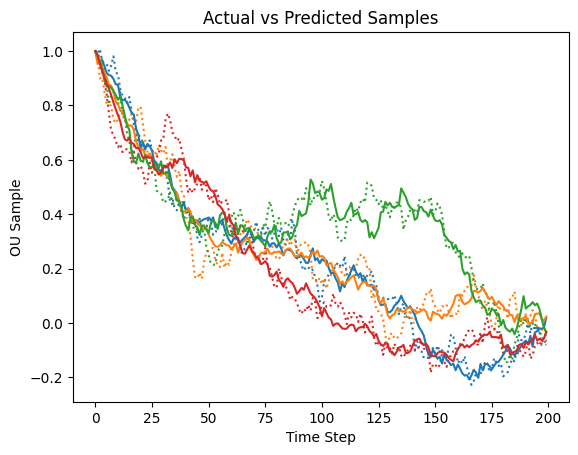

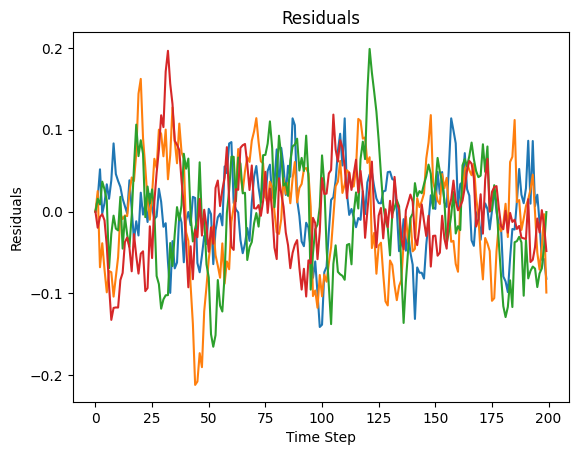

In [4]:
###### Test dense layer ######

def train_sampling(x_train, y_train, n_layers, n_width, random_seed=3, SWIM=DenseSWIM):
    steps = []
    for k_layer in range(n_layers):
        steps.append((f"fcn{k_layer+1}", SWIM(layer_width=n_width, 
                                                   activation="relu", 
                                                   parameter_sampler='relu', 
                                                   random_seed=1 + random_seed + k_layer * 1234)))
    steps.append(("ridgeCV", RidgeCV(alphas=[2**i for i in range(-5, 2)])))
    model = Pipeline(steps=steps, verbose=False)
    t0 = time()
    model.fit(x_train, y_train)
    t_fit = time()
    return model, t_fit-t0


n_layers = 1
n_width = 199

model, time_fit = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
pred = model.predict(test_W)
eval_scores(pred, test_OU)
print("alpha:", model.named_steps['ridgeCV'].alpha_)

# Predict the OU samples using the noise
pred = model.predict(test_W)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# SWIM residual

Relative L2 error: 0.03375427994325394
Test R^2 score: 0.9850509300830194
Test MAPE: 0.6655464272848575
alpha: 0.25


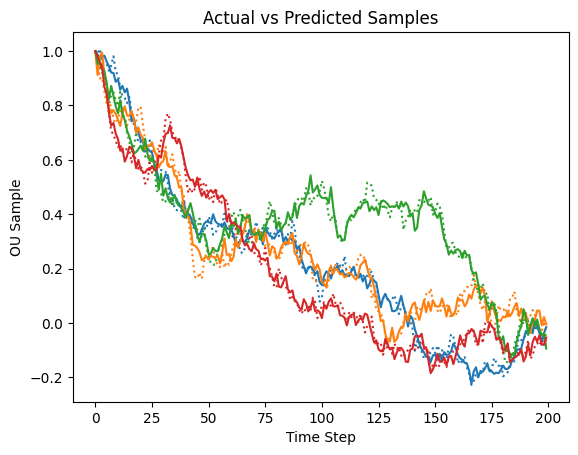

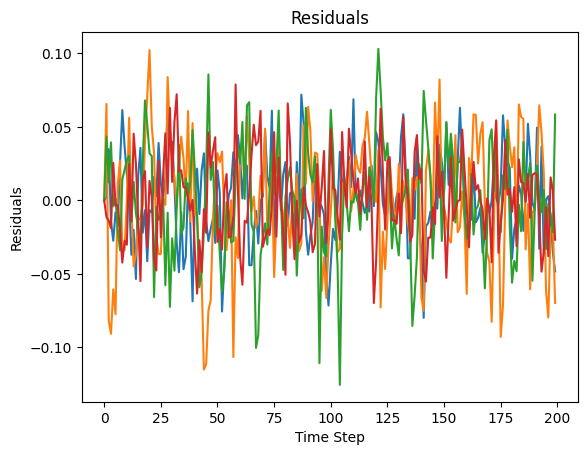

In [5]:
###### Test dense layer ######
from SWIM_residual_mlp import DenseResSWIM

model, time_fit = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM)
pred = model.predict(test_W)
eval_scores(pred, test_OU)
print("alpha:", model.named_steps['ridgeCV'].alpha_)

# Predict the OU samples using the noise
pred = model.predict(test_W)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# Random feature network

Best alpha: 0.1
Relative L2 error: 0.03454452742283165
Test R^2 score: 0.9859256134866342
Test MAPE: 0.6976790681706387


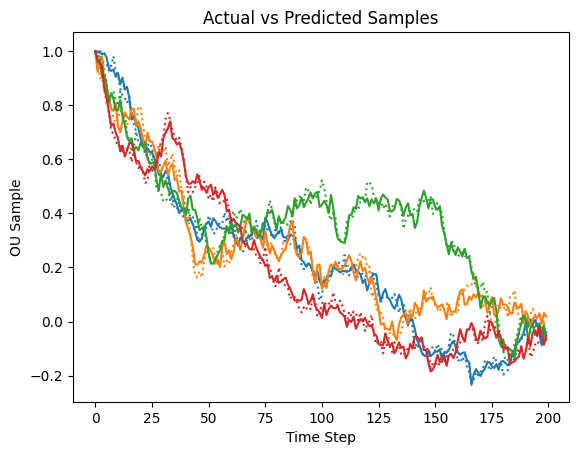

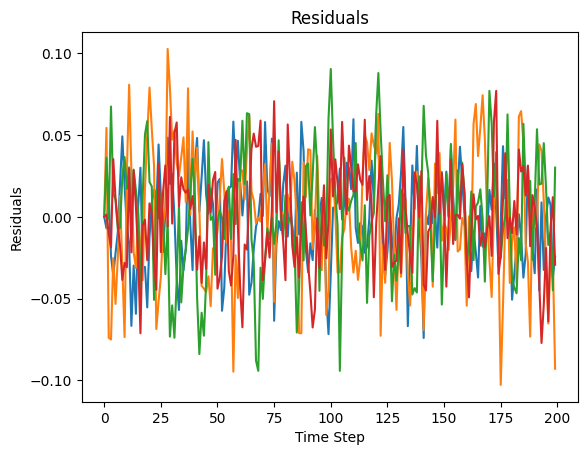

In [6]:
import torch
import torch.nn as nn
import torchvision as tv

class random_MLP():
    def __init__(self, in_channels, n_layers, n_width, alphas = [0.01, 0.1, 1, 10]):
        self.mlp = tv.ops.MLP(
            in_channels=in_channels,
            hidden_channels=[n_width]*n_layers,
            bias=True
            )
        
        self.ridge = RidgeCV(alphas=alphas)
    

    def fit(self, x, y):
        x = torch.from_numpy(x).float()
        x = self.mlp(x).detach().numpy()
        self.ridge.fit(x, y)
        print("Best alpha:", self.ridge.alpha_)

    def predict(self, x):
        x = torch.from_numpy(x).float()
        x = self.mlp(x).detach().numpy()
        return self.ridge.predict(x)
    

model = random_MLP(
    in_channels=n_steps-1,
    n_layers=n_layers,
    n_width=n_width,
    )
model.fit(train_W, train_OU)

# Predict the OU samples using the noise
pred = model.predict(test_W)
eval_scores(pred, test_OU)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# TEST JAX MODEL TO SEE IF WE GET SIMILAR RESULTS

In [7]:
from typing import Tuple, List, Union, Any, Optional, Dict, Set, Literal, Callable
import os
import sys
from functools import partial
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jaxtyping import Array, Float, Int, PRNGKeyArray
from jax.random import PRNGKey
import aeon
import pandas as pd

from features.sig_trp import SigVanillaTensorizedRandProj, SigRBFTensorizedRandProj
from features.sig import SigTransform, LogSigTransform
from features.base import TimeseriesFeatureTransformer, TabularTimeseriesFeatures, RandomGuesser
from features.sig_neural import RandomizedSignature
from utils.utils import print_name, print_shape
from preprocessing.timeseries_augmentation import normalize_mean_std_traindata, normalize_streams, augment_time, add_basepoint_zero

jax.config.update('jax_platform_name', 'cpu') # Used to set the platform (cpu, gpu, etc.)
np.set_printoptions(precision=3, threshold=5) # Print options

2024-09-07 19:34:04.645678: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Relative L2 error: 0.07332852468256983
Test R^2 score: 0.9520870763767595
Test MAPE: 1.128209891784647
alpha: 0.5


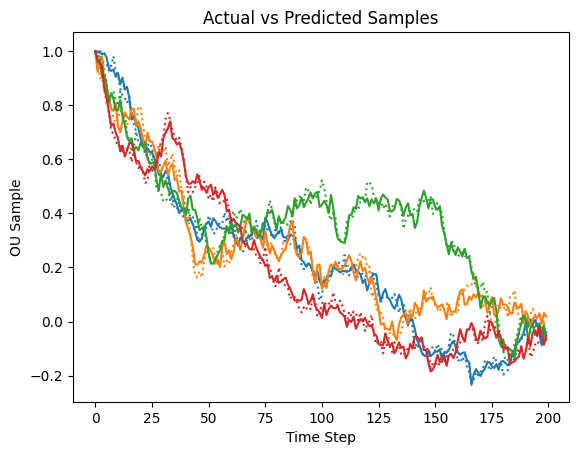

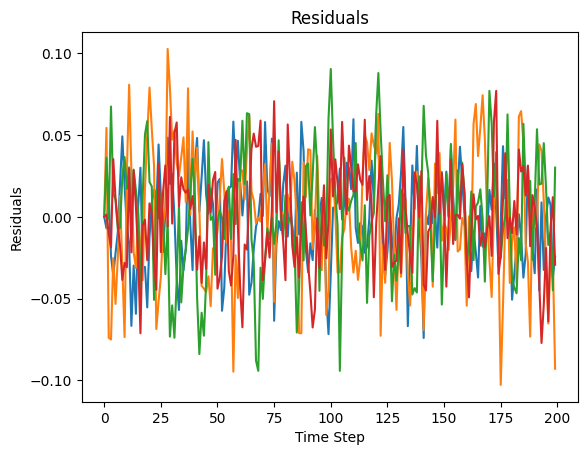

In [8]:
###### Test jax dense layer ######
from features.SWIM_mlp import SWIM_MLP

def train_sampling_JAX(x_train, y_train, n_layers, n_width, seed=PRNGKey(2), add_residual=False):
    swim_model = SWIM_MLP(seed, n_width, n_layers, add_residual)
    ridge = RidgeCV(alphas=[2**i for i in range(-5, 2)])

    swim_model.fit(x_train, y_train)
    ridge.fit(np.array(swim_model.transform(x_train)), y_train)

    return swim_model, ridge

swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
pred = ridge.predict(np.array(swim_model.transform(test_W)))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Predict the OU samples using the noise
pred = model.predict(test_W)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

Relative L2 error: 0.03363340122926351
Test R^2 score: 0.985225608168395
Test MAPE: 0.6849138831631475
alpha: 0.125


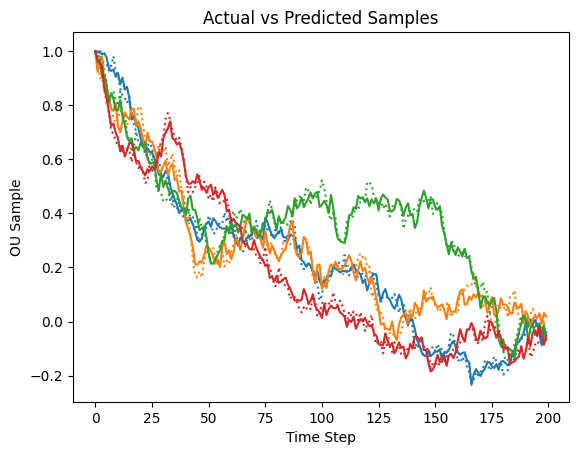

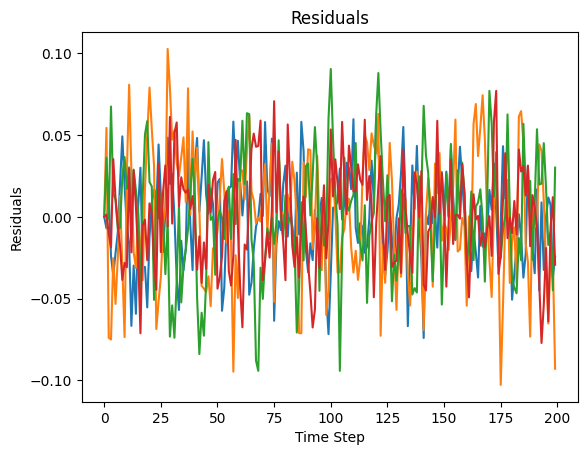

In [9]:
###### Test jax residual ######
from features.SWIM_mlp import SWIM_MLP

swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, add_residual=True)
pred = ridge.predict(np.array(swim_model.transform(test_W)))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Predict the OU samples using the noise
pred = model.predict(test_W)
# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

Relative L2 error: 0.06826200328890161
Test R^2 score: 0.9527079655677458
Test MAPE: 1.0702226978091423
Relative L2 error: 0.03375427994325394
Test R^2 score: 0.9850509300830194
Test MAPE: 0.6655464272848575
Best alpha: 0.1
Relative L2 error: 0.03384267499625613
Test R^2 score: 0.9859369957758563
Test MAPE: 0.6559322552872007
Relative L2 error: 0.07332852468256983
Test R^2 score: 0.9520870763767595
Test MAPE: 1.128209891784647
Relative L2 error: 0.03363340122926351
Test R^2 score: 0.985225608168395
Test MAPE: 0.6849138831631475
Relative L2 error: 0.10142242935045842
Test R^2 score: 0.923873112062447
Test MAPE: 1.2912052375393295
Relative L2 error: 0.03496339438688288
Test R^2 score: 0.9833544656912871
Test MAPE: 0.7310249133420793
Best alpha: 0.1
Relative L2 error: 0.06221756727885904
Test R^2 score: 0.9599517756053112
Test MAPE: 0.909254087434196
Relative L2 error: 0.10508659158703433
Test R^2 score: 0.9204224408712447
Test MAPE: 1.3286003525411543
Relative L2 error: 0.035227363681218

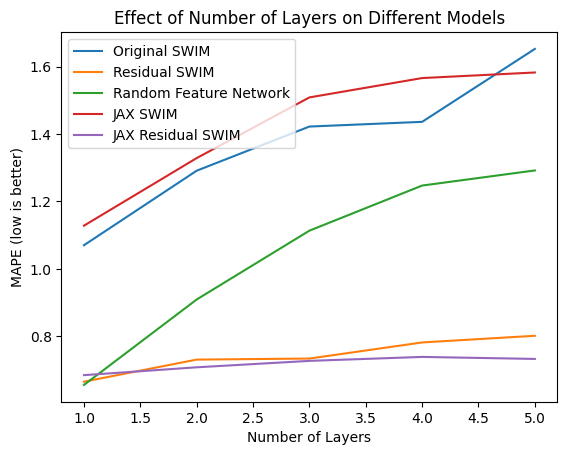

In [10]:
# Define the number of layers to test
num_layers = [1, 2, 3, 4, 5]

# Initialize lists to store the evaluation scores for each model
original_swim_scores = []
residual_swim_scores = []
random_feature_scores = []
jax_swim_scores = []
jax_residual_swim_scores = []

# Evaluate the models for each number of layers
for n_layers in num_layers:
    # Evaluate the original SWIM model
    model, _ = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
    pred = model.predict(test_W)
    original_swim_scores.append(eval_scores(pred, test_OU))
    
    # Evaluate the residual SWIM model
    model, _ = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM)
    pred = model.predict(test_W)
    residual_swim_scores.append(eval_scores(pred, test_OU))
    
    # Evaluate the random feature network model
    model = random_MLP(in_channels=n_steps-1, n_layers=n_layers, n_width=n_width)
    model.fit(train_W, train_OU)
    pred = model.predict(test_W)
    random_feature_scores.append(eval_scores(pred, test_OU))
    
    # Evaluate the JAX SWIM model
    swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
    pred = ridge.predict(np.array(swim_model.transform(test_W)))
    jax_swim_scores.append(eval_scores(pred, test_OU))
    
    # Evaluate the JAX residual SWIM model
    swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, add_residual=True)
    pred = ridge.predict(np.array(swim_model.transform(test_W)))
    jax_residual_swim_scores.append(eval_scores(pred, test_OU))

# Plot the evaluation scores for each model
plt.plot(num_layers, original_swim_scores, label='Original SWIM')
plt.plot(num_layers, residual_swim_scores, label='Residual SWIM')
plt.plot(num_layers, random_feature_scores, label='Random Feature Network')
plt.plot(num_layers, jax_swim_scores, label='JAX SWIM')
plt.plot(num_layers, jax_residual_swim_scores, label='JAX Residual SWIM')
plt.xlabel('Number of Layers')
plt.ylabel('MAPE (low is better)')
plt.title('Effect of Number of Layers on Different Models')
plt.legend()
plt.show()

Relative L2 error: 0.18354172354371082
Test R^2 score: 0.84479599707407
Test MAPE: 1.7625457152322672
Relative L2 error: 0.13429965556767873
Test R^2 score: 0.8948078456396947
Test MAPE: 1.5158230508174153
Best alpha: 0.01
Relative L2 error: 0.222682265560612
Test R^2 score: 0.8260129848194018
Test MAPE: 1.8941144445658682
Relative L2 error: 0.16467896250121627
Test R^2 score: 0.8669339228304559
Test MAPE: 1.4354367572036397
Relative L2 error: 0.11083777480261595
Test R^2 score: 0.9075520971320963
Test MAPE: 1.455895636501447
Relative L2 error: 0.176673272647642
Test R^2 score: 0.8602987964748264
Test MAPE: 1.8297542482006015
Relative L2 error: 0.11015874491118066
Test R^2 score: 0.9208396735656181
Test MAPE: 1.300344872102078
Best alpha: 0.01
Relative L2 error: 0.17301869693309005
Test R^2 score: 0.8388933309977931
Test MAPE: 1.8498191123670213
Relative L2 error: 0.16669378522394587
Test R^2 score: 0.8707226164501719
Test MAPE: 1.5704301633929447
Relative L2 error: 0.11426459178596302

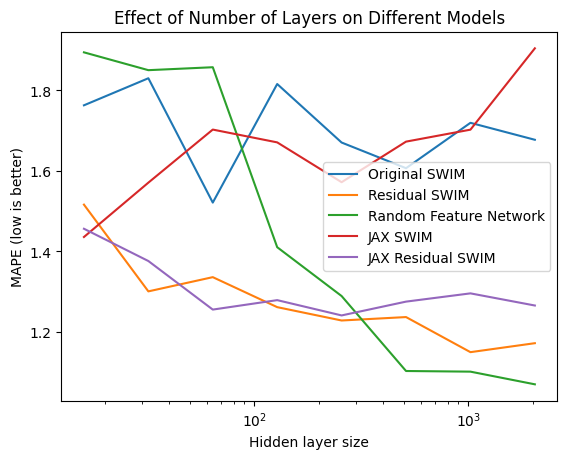

In [20]:
def plot_vs_hiddensize(hidden_sizes, num_layers):
    # Initialize lists to store the evaluation scores for each model
    original_swim_scores = []
    residual_swim_scores = []
    random_feature_scores = []
    jax_swim_scores = []
    jax_residual_swim_scores = []

    # Evaluate the models for each number of layers
    for h in hidden_sizes:
        # Evaluate the original SWIM model
        model, _ = train_sampling(n_layers=n_layers, n_width=h, x_train=train_W, y_train=train_OU)
        pred = model.predict(test_W)
        original_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the residual SWIM model
        model, _ = train_sampling(n_layers=n_layers, n_width=h, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM)
        pred = model.predict(test_W)
        residual_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the random feature network model
        model = random_MLP(in_channels=n_steps-1, n_layers=n_layers, n_width=h)
        model.fit(train_W, train_OU)
        pred = model.predict(test_W)
        random_feature_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the JAX SWIM model
        swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=h, x_train=train_W, y_train=train_OU)
        pred = ridge.predict(np.array(swim_model.transform(test_W)))
        jax_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the JAX residual SWIM model
        swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=h, x_train=train_W, y_train=train_OU, add_residual=True)
        pred = ridge.predict(np.array(swim_model.transform(test_W)))
        jax_residual_swim_scores.append(eval_scores(pred, test_OU))

    # Plot the evaluation scores for each model
    plt.semilogx(hidden_sizes, original_swim_scores, label='Original SWIM')
    plt.semilogx(hidden_sizes, residual_swim_scores, label='Residual SWIM')
    plt.semilogx(hidden_sizes, random_feature_scores, label='Random Feature Network')
    plt.semilogx(hidden_sizes, jax_swim_scores, label='JAX SWIM')
    plt.semilogx(hidden_sizes, jax_residual_swim_scores, label='JAX Residual SWIM')
    plt.xlabel('Hidden layer size')
    plt.ylabel('MAPE (low is better)')
    plt.title('Effect of Number of Layers on Different Models')
    plt.legend()
    plt.show()

plot_vs_hiddensize([16, 32, 64, 128, 256, 512, 1024, 2048], 3)